In [16]:
%run ../modules.ipynb
# Change this cell to change the kernel function throughout

#tutorial
sys.path.append('../0. kernel-tutorials/')
# Local Utilities for Notebook
from utilities.kernels import linear_kernel, gaussian_kernel
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_base, 
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
cmaps = get_cmaps()
plt.style.use("../0. kernel-tutorials/utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

kernel_params = {"kernel": "rbf", "gamma": 1}
kernel_func = partial(rbf_kernel, gamma=1)
kernel_type = "gaussian"

n_FPS = 5000
n_frames = 50000

alphas=np.logspace(-0, -6, 30)

../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'cbarHot' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'cbarBWR' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:35: UserWarning: Trying to register the cmap 'cbarPhi' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'cbarHot_0.3_1.05' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'bone_r_0.2_1.0' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'Reds_0.3_1.0' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/ut

In [17]:
npzfile = np.load("../datasets/E_form_MP.npz")
npzfile.files

['indices', 'magic', 'soap_v', 'E_form']

In [18]:
X_raw=npzfile['soap_v']
y_raw=npzfile['E_form']
y_atom=npzfile['magic']

In [19]:
X_raw.shape

(50000, 5000)

In [20]:
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
    np.arange(X_raw.shape[0]), X_raw, y_raw, train_size=0.8
)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_raw)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_raw)

# Center total dataset
X = x_scaler.transform(X_raw)
Y = y_scaler.transform(y_raw)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(40000, 5000) (10000, 5000) (40000, 1) (10000, 1)


In [21]:
# ridgecv = RidgeCV(cv=4,fit_intercept=False, alphas=alphas)
# ridgecv.fit(X_train, y_train)
# yp_test=ridgecv.predict(X_test)
# yp_train=ridgecv.predict(X_train)
# print('R^2 of training is ', ridgecv.score(X_train,y_train))
# print('R^2 of testing is ', ridgecv.score(X_test,y_test))
# print('Best regularization is ', ridgecv.alpha_)
# fig, (ax_train, ax_test)=plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
# ax_train.scatter(y_train, yp_train, c=np.abs(y_train - yp_train), cmap="bone_r", ec="k")
# ax_test.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r", ec="k")

# bounds=(np.min((Y.min(), yp_train.min(), yp_test.min())), 
#        np.max((Y.max(), yp_train.max(), yp_test.max()))
#        )

# ax_train.plot(bounds,bounds, 'r--')
# ax_train.set_title('Training set')
# ax_test.set_title('Testing set')
# ax_test.plot(bounds,bounds, 'r--')
# plt.title('Materials Project Energy Regression')


In [22]:
"""MAKING PREDICTION OF ENERGIES ON 3DCD DATASET"""

#dataset load
len_dataset=79855
load_profile('egazzarr')
qb = QueryBuilder()
qb.append(orm.StructureData)
select=n_frames
qb_red=random.sample(qb.all(), select)

frames_tot_exp=[]
magic=[]
for [structure_data] in qb_red:
    frame=structure_data.get_ase()
    frame.wrap(eps=1e-12)
    frames_tot_exp.append(frame)
    natom=len(frame)
    if natom%4==0:
        magic.append(int(1))
    else:
        magic.append(int(0))
    
species = list(set([int(n) for frame in frames_tot_exp for n in frame.numbers]))
print(species)

hypers = dict(
    soap_type="PowerSpectrum",
    interaction_cutoff=3.5,
    max_radial=4,
    max_angular=4,
    gaussian_sigma_type="Constant",
    gaussian_sigma_constant=0.5,
    cutoff_smooth_width=0.5,
    global_species=species,
    expansion_by_species_method="user defined",
    normalize=False,
)
fps_soap = SOAP(
    **hypers,
)

idx_for_fps = np.random.randint(0, len(frames_tot_exp), n_FPS) 
frames_for_fps = [frames_tot_exp[i] for i in idx_for_fps]

X_temp = np.array(
    [
        np.mean(fps_soap.transform([frame]).get_features(fps_soap), axis=0)
        for frame in frames_for_fps
    ]
)

THRESH = 1e-12
high_var_features = np.where(np.var(X_temp - X_temp.mean(axis=0), axis=0) > THRESH)[0]
X_temp = X_temp[:, high_var_features]

X_raw_exp = StandardFlexibleScaler(column_wise=False).fit_transform(X_temp)
del X_temp # save on memory

# fps = FPS(n_to_select=n_FPS, progress_bar=True).fit(X_raw)
fps = FPS(n_FPS).fit(X_raw_exp)
del X_raw_exp # save on memory

u_species = np.unique(species)
sp_pairs = fps_soap.get_keys(u_species)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]


In [23]:
# high_var_features[fps.selected_idx_].shape
coefficient_subselection = np.zeros((n_FPS, 5))
index_mapping = get_power_spectrum_index_mapping(
    sp_pairs, n_max=hypers["max_radial"], l_max=hypers["max_angular"] + 1
)

for fi, i in enumerate(high_var_features[fps.selected_idx_]):
    coefficient_subselection[fi] = [
        index_mapping[i][k] for k in ["a", "b", "n1", "n2", "l"]
    ]

In [24]:
print(coefficient_subselection)

coefficient_subselection_dict = {
    "a": coefficient_subselection[:, 0].tolist(),
    "b": coefficient_subselection[:, 1].tolist(),
    "n1": coefficient_subselection[:, 2].tolist(),
    "n2": coefficient_subselection[:, 3].tolist(),
    "l": coefficient_subselection[:, 4].tolist(),
}

soap = SOAP(**hypers, coefficient_subselection=coefficient_subselection_dict)


[[  1.   1.   0.   0.   0.]
 [  8.   8.   2.   2.   0.]
 [  9.   9.   0.   0.   0.]
 ..., 
 [ 40.  40.   1.   3.   3.]
 [ 29.  49.   2.   3.   0.]
 [  8.  19.   2.   3.   2.]]


In [25]:
frame_idx = np.random.randint(0, len(frames_tot_exp), n_frames)
my_frames = [frames_tot_exp[i] for i in frame_idx]

X_raw_exp = np.zeros((len(my_frames), n_FPS))
for fi, frame in enumerate(my_frames):
    X_raw_exp[fi] = np.mean(soap.transform([frame]).get_features(soap), axis=0)


In [26]:
x_scaler_exp = StandardFlexibleScaler(column_wise=False).fit(X_raw_exp)

X_raw_exp = x_scaler_exp.transform(X_raw_exp)

In [27]:
y_atom_exp = np.array(magic).reshape(-1, 1)[frame_idx]

In [28]:
X_train.shape,y_train.shape, X_test.shape

((40000, 5000), (40000, 1), (10000, 5000))

In [29]:
ridgecv = RidgeCV(cv=4,fit_intercept=False, alphas=alphas)
ridgecv.fit(X_train, y_train)

y_exp=ridgecv.predict(X_raw_exp)
y_scaler_exp = StandardFlexibleScaler(column_wise=True).fit(y_exp)
y_exp = y_scaler_exp.transform(y_exp)

yp_train=ridgecv.predict(X_train)
print(y_exp)


[[ 0.30773451]
 [ 0.05556162]
 [ 0.43669949]
 ..., 
 [-0.57814534]
 [ 0.065723  ]
 [ 1.72515966]]


In [30]:
print('R^2 of training is ', ridgecv.score(X_train,y_train))
print('R^2 of testing is ', ridgecv.score(X_raw_exp,y_exp))
print('Best regularization is ', ridgecv.alpha_)

R^2 of training is  0.965700151623
R^2 of testing is  -0.0905000661027
Best regularization is  0.00204335971786


In [31]:
mixing = 0.5
pcovr = PCovR(mixing=mixing,
              n_components=2)
pcovr.fit(X_raw_exp,y_exp)
T = pcovr.transform(X_raw_exp)
yp = pcovr.predict(X_raw_exp)


R^2 =  1.50684450469e+25


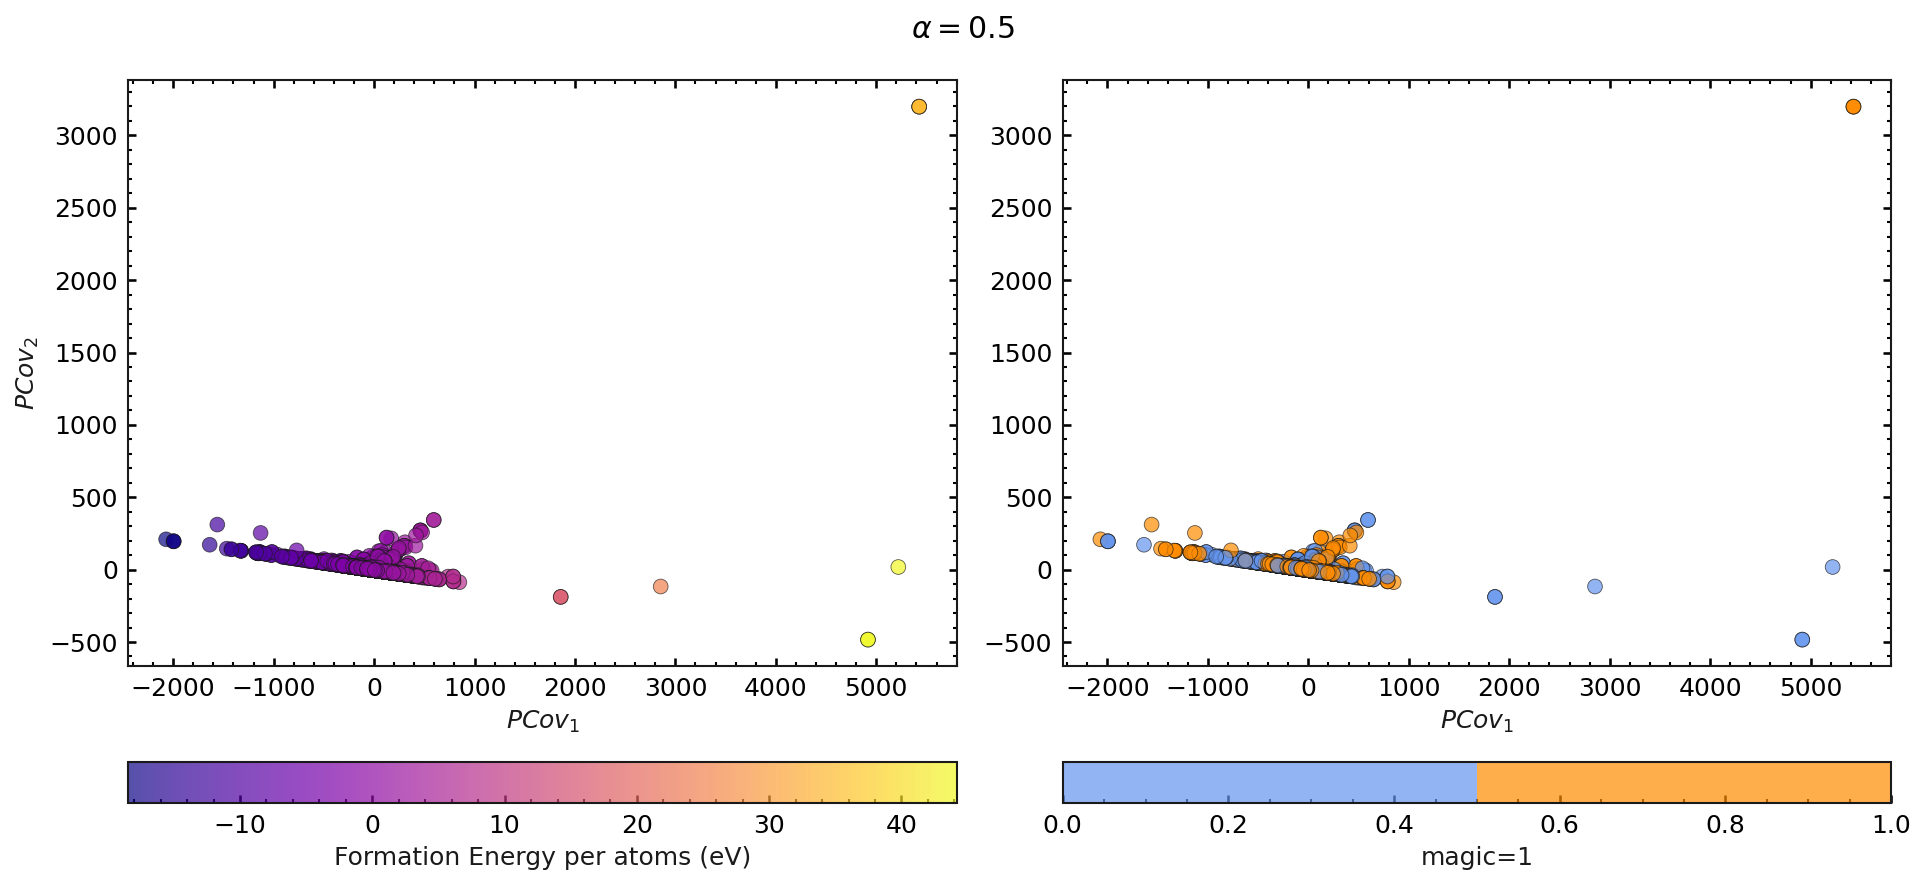

In [32]:
fig, ((axT, axM), (caxT, caxM,)) = plt.subplots(
    2, 2, figsize=(13, 6), gridspec_kw=dict(height_ratios=(1, 0.07))
)

scatT = axT.scatter(T[:, 0], T[:, 1], s=50, alpha=0.7, c=y_exp, cmap='plasma', edgecolor="k")
axT.set_xlabel(r"$PCov_1$")
axT.set_ylabel(r"$PCov_2$")

fig.colorbar(scatT, cax=caxT, label="Formation Energy per atoms (eV)", orientation="horizontal")

scatM = axM.scatter(T[:, 0], T[:, 1], s=50, alpha=0.7, c=y_atom_exp, cmap = colors.ListedColormap(['cornflowerblue', 'darkorange']), edgecolor="k")
axM.set_xlabel(r"$PCov_1$")

fig.colorbar(scatM, cax=caxM, label="magic=1", orientation="horizontal")

# scaty = axy.scatter(Y, yp, s=50, alpha=0.7, c=np.abs(Y - yp), cmap='bone_r', edgecolor="k")
# axy.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
# axy.set_xlabel(r"True Y")
# axy.set_ylabel(r"Predicted Y")
# axy.set_title("Regression")
# fig.colorbar(scaty, cax=caxy, label='Error in Y, R^2 = {0:1.2f}'.format(pcovr.score(X,Y)), orientation="horizontal")

fig.suptitle(r"$\alpha=$" + str(mixing))
fig.tight_layout()
print('R^2 = ', pcovr.score(X,Y))